In [1]:
import warnings
warnings.filterwarnings('ignore')


# routines

In [147]:
def spike_counts(V, Ek):
    count = 0
    if sum(V<Ek)>=1:
        for i in range(1, len(V)):
            if V[i] < Ek and V[i - 1] > Ek:
                count += 1
    return count

In [143]:
sum(V<Ek)

1

# LIF model

In [180]:
import numpy as np
import matplotlib.pyplot as plt

def LIF(tau_m=10e-3, 
        R_m=100e6, 
        I={}, 
        dt=1,
        t_final={},
        numMethod='FE', 
        Ena=40, 
        Ek=-75):

    """
    Simulates the Leaky Integrate-and-Fire model of a neuron using different integration methods.
    
    Parameters:
        tau_m (float): membrane time constant (in seconds)
        R_m (float): membrane resistance (in ohms)
        V_rest (float): resting potential (in volts)
        I (callable): input current function of time (in amperes)
        V_init (float): initial membrane potential (in volts)
        dt (float): time step (in seconds)
        t_final (float): final simulation time (in seconds)
        
    Returns:
        t (array): time values (in seconds)
        V (array): membrane potential values (in volts)
    """
    
    # Initialize time and voltage arrays
    t = np.arange(0, t_final, dt)
    V = np.zeros_like(t)
    V[0] = Ek
    V_rest = Ek
    hyper = 15
   
    if numMethod == 'FE':
        # Numerical integration using Forward Euler method
        for i in range(1, len(t)):
            dVdt = (-(V[i-1] - V_rest) + R_m * I(t[i-1])) / tau_m
            V[i] = V[i-1] + dVdt * dt

            # Check for spike
            if V[i] >= Ena:
                V[i] = V_rest-hyper
                
    if numMethod == 'BE':
        # Numerical integration using Backward Euler method
        for i in range(1, len(t)):
            dVdt=((V_rest-V[i-1] + R_m*I(t[i]))/tau_m) / (1+dt/tau_m)
            V[i] = V[i-1] + dVdt * dt

            # Check for spike
            if V[i] >= Ena:
                V[i] = V_rest-hyper
                
    if numMethod == 'Heun':
        # Numerical integration using Heun's method
        for i in range(1, len(t)):
            k1 = (-(V[i-1] - V_rest) + R_m * I(t[i-1])) / tau_m
            k2 = (-(V[i-1] + dt*k1*tau_m - V_rest) + R_m * I(t[i])) / tau_m
            V[i] = V[i-1] + 0.5*dt*(k1 + k2)

            # Check for spike
            if V[i] >= Ena:
                V[i] = V_rest-hyper
                
    if numMethod == 'RK4':
        # Numerical integration using Runge-Kutta 4 method
        for i in range(1, len(t)):
            k1 = dt * ((-(V[i-1] - V_rest) + R_m * I(t[i-1])) / tau_m)
            k2 = dt * ((-(V[i-1] + k1 / 2 - V_rest) + R_m * I(t[i-1] + dt / 2)) / tau_m)
            k3 = dt * ((-(V[i-1] + k2 / 2 - V_rest) + R_m * I(t[i-1] + dt / 2)) / tau_m)
            k4 = dt * ((-(V[i-1] + k3 - V_rest) + R_m * I(t[i-1] + dt)) / tau_m)

            V[i] = V[i-1] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)

            # Check for spike
            if V[i] >= Ena:
                V[i] = V_rest-hyper
            
    
    return t, V



# some experiments

## the smallest current to get a spike

spike count with FE: 1
mp max with FE: 25.000000000000014
spike count with BE: 1
mp max with BE: 15.90909090909092
spike count with Heun: 1
mp max with Heun: -24.999999999999993
spike count with RK4: 0
mp max with RK4: 39.831280283854184


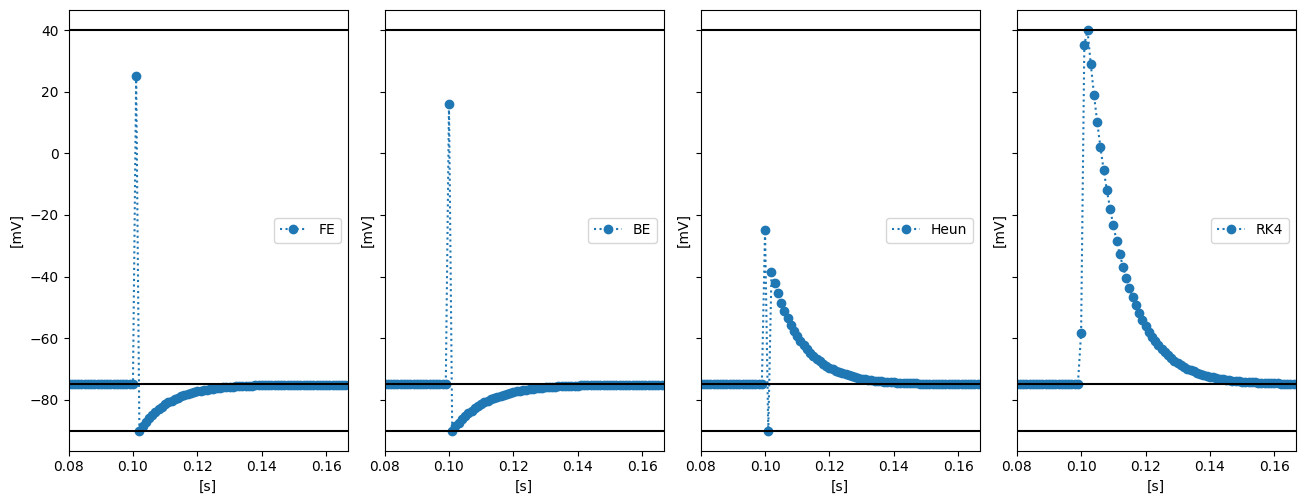

In [178]:
dt = 0.001 # PARAMETER OF INTEREST

# Define input current function
def I(t):
    if t >= 0.100 and t <= 0.100+0.001:
        return 10e-6 # 
    else:
        return 0.0 # no input current otherwise  
    
# Set LIF model parameters
tau_m = 10e-3 # 10ms
R_m = 100e6 # 100Mohm
t_final = 0.5 # simulation time
Ena=40
Ek=-75
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(13,5))
fig.tight_layout()
for i, nm in enumerate(['FE', 'BE', 'Heun', 'RK4']):

    t, V = LIF(tau_m, R_m, I, dt, t_final, numMethod=nm, Ena=Ena, Ek=Ek)
    # Plot voltage trace
    ax[i].plot(t, V, ':o', label=nm)
    ax[i].set_xlabel('[s]')
    ax[i].set_ylabel('[mV]')
    ax[i].axhline(Ena, c='k')
    ax[i].axhline(Ek, c='k')
    ax[i].set_xlim(0.08, t_final/3)
    ax[i].legend()
    ax[i].axhline(Ek-15, c='k')
    print(f'spike count with {nm}: {spike_counts(V, Ek)}')
    print(f'mp max with {nm}: {max(V)}')
   

# try with Ena=39mv

## sequential current injection

spike count with FE: 5
spike count with BE: 5
spike count with Heun: 6
spike count with RK4: 5


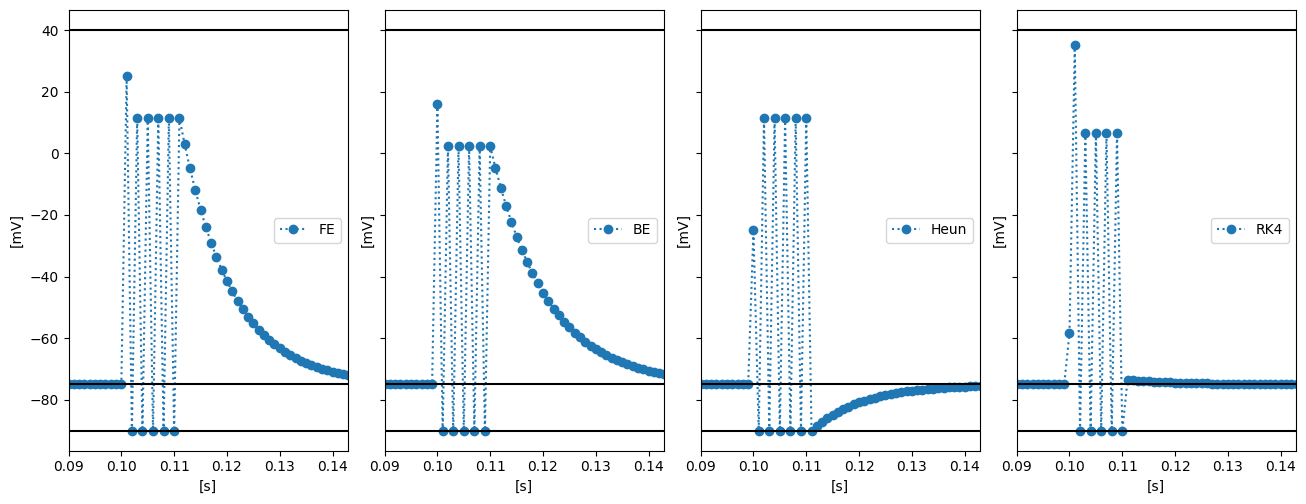

In [173]:
dt = 0.001 # PARAMETER OF INTEREST
n = 10
# Define input current function
def I(t):
    if t >= 0.100 and t <= 0.100+0.001*n:
        return 10e-6 # 
    else:
        return 0.0 # no input current otherwise  
    
# Set LIF model parameters
tau_m = 10e-3 # 10ms
R_m = 100e6 # 100Mohm
t_final = 0.5 # simulation time
Ena=40
Ek=-75
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(13,5))
fig.tight_layout()
for i, nm in enumerate(['FE', 'BE', 'Heun', 'RK4']):
    t, V = LIF(tau_m, R_m, I, dt, t_final, numMethod=nm, Ena=Ena, Ek=Ek)
    # Plot voltage trace
    ax[i].plot(t, V, ':o', label=nm)
    ax[i].set_xlabel('[s]')
    ax[i].set_ylabel('[mV]')
    ax[i].axhline(Ena, c='k')
    ax[i].axhline(Ek, c='k')
    ax[i].axhline(Ek-15, c='k')
    ax[i].set_xlim(0.09, t_final/3.5)
    ax[i].legend()
    print(f'spike count with {nm}: {spike_counts(V, Ek)}')




## sequential current injection (long time)

spike count with FE: 449
spike count with BE: 450
spike count with Heun: 450
spike count with RK4: 449


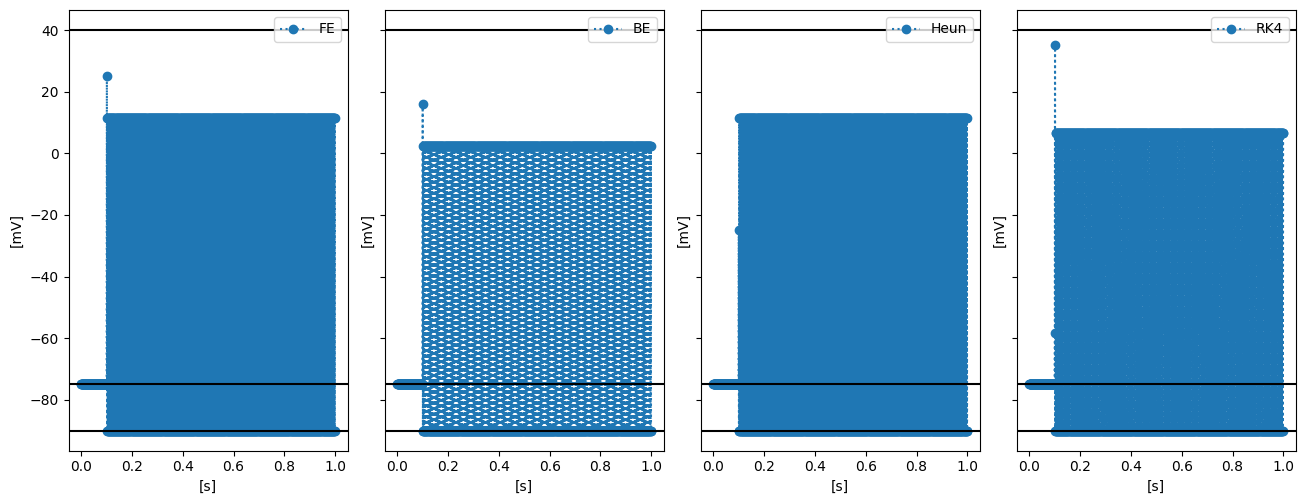

In [177]:
dt = 0.001 # PARAMETER OF INTEREST
n = 1000
# Define input current function
def I(t):
    if t >= 0.100 and t <= 0.100+0.001*n:
        return 10e-6 # 
    else:
        return 0.0 # no input current otherwise  
    
# Set LIF model parameters
tau_m = 10e-3 # 10ms
R_m = 100e6 # 100Mohm
t_final = 1 # simulation time [s]
Ena=40
Ek=-75
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(13,5))
fig.tight_layout()
for i, nm in enumerate(['FE', 'BE', 'Heun', 'RK4']):
    start_time = time.time()
    t, V = LIF(tau_m, R_m, I, dt, t_final, numMethod=nm, Ena=Ena, Ek=Ek)
    # Plot voltage trace
    ax[i].plot(t, V, ':o', label=nm)
    ax[i].set_xlabel('[s]')
    ax[i].set_ylabel('[mV]')
    ax[i].axhline(Ena, c='k')
    ax[i].axhline(Ek, c='k')
    ax[i].axhline(Ek-15, c='k')
    #ax[i].set_xlim(0.09, t_final/3.5)
    ax[i].legend()
    print(f'spike count with {nm}: {spike_counts(V, Ek)}')




# I-V curve

In [181]:
# start from here

# comparison 

## computational time

### one-input-current

In [7]:
# Define input current function
def I(t):
    if t >= 0.1 and t <= 0.11:
        return 1e-9 # 1nA current input for 50ms
    else:
        return 0.0 # no input current otherwise  

In [8]:
# dt di riferimento 0.001
import time

dt = 0.001
for numMethod in ['FE', 'BE', 'Heun', 'RK4']:
    start_time = time.time()    
    t, V = LIF(tau_m, R_m, V_rest, I, V_init, dt, t_final, numMethod)
    end_time = time.time()
    time_taken = end_time - start_time
    print(numMethod + " time taken: ", round(time_taken,10), "seconds")




FE time taken:  0.0 seconds
BE time taken:  0.0 seconds
Heun time taken:  0.0009994507 seconds
RK4 time taken:  0.0 seconds


In [9]:
# un decimo di dt di riferimento
import time

dt = 0.001/10
for numMethod in ['FE', 'BE', 'Heun', 'RK4']:
    start_time = time.time()    
    t, V = LIF(tau_m, R_m, V_rest, I, V_init, dt, t_final, numMethod)
    end_time = time.time()
    time_taken = end_time - start_time
    print(numMethod + " time taken: ", round(time_taken,6), "seconds")



FE time taken:  0.004001 seconds
BE time taken:  0.002998 seconds
Heun time taken:  0.00429 seconds
RK4 time taken:  0.009002 seconds


In [10]:
# un centesimo di dt di riferimento

import time

dt = 0.001/100
for numMethod in ['FE', 'BE', 'Heun', 'RK4']:
    start_time = time.time()    
    t, V = LIF(tau_m, R_m, V_rest, I, V_init, dt, t_final, numMethod)
    end_time = time.time()
    time_taken = end_time - start_time
    print(numMethod + " time taken: ", round(time_taken,6), "seconds")

FE time taken:  0.024176 seconds
BE time taken:  0.026002 seconds
Heun time taken:  0.028213 seconds
RK4 time taken:  0.101766 seconds


In [11]:
# un millesimo di dt di riferimento

import time

dt = 0.001/1000
for numMethod in ['FE', 'BE', 'Heun', 'RK4']:
    start_time = time.time()    
    t, V = LIF(tau_m, R_m, V_rest, I, V_init, dt, t_final, numMethod)
    end_time = time.time()
    time_taken = end_time - start_time
    print(numMethod + " time taken: ", round(time_taken,6), "seconds")

FE time taken:  0.229598 seconds
BE time taken:  0.229217 seconds
Heun time taken:  0.425584 seconds
RK4 time taken:  0.90285 seconds


### multiple-input-current

In [12]:
def I(t):
    pulse_dur = 0.01 # duration of each pulse in seconds
    pulse_interval = 0.05 # time interval between pulses in seconds
    num_pulses = 15 # number of pulses
    
    pulse_start_times = np.arange(0.1, 0.1 + num_pulses*pulse_interval, pulse_interval)
    
    for start_time in pulse_start_times:
        if t >= start_time and t <= start_time + pulse_dur:
            return 1e-9 # 1nA current input for pulse duration
    return 0.0 # no input current otherwise


FE time taken:  0.001 seconds


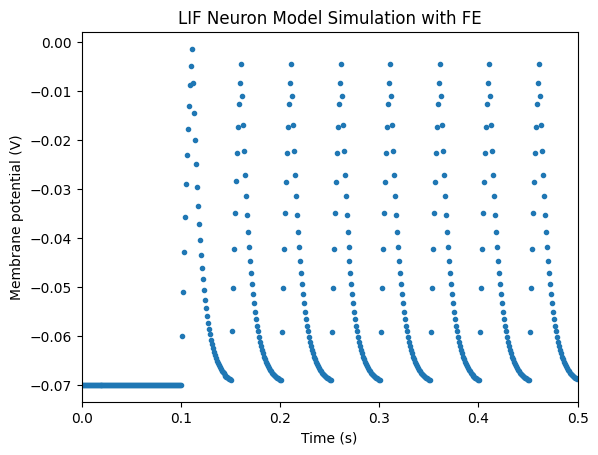

BE time taken:  0.001 seconds


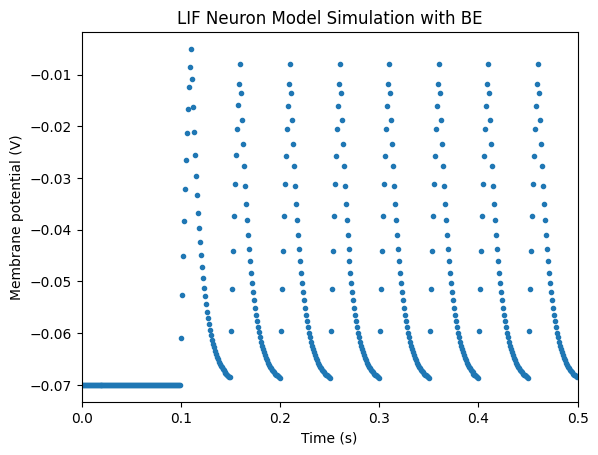

Heun time taken:  0.002206 seconds


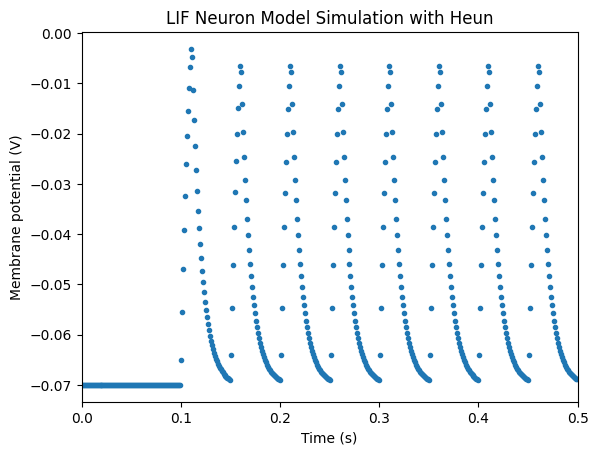

RK4 time taken:  0.004654 seconds


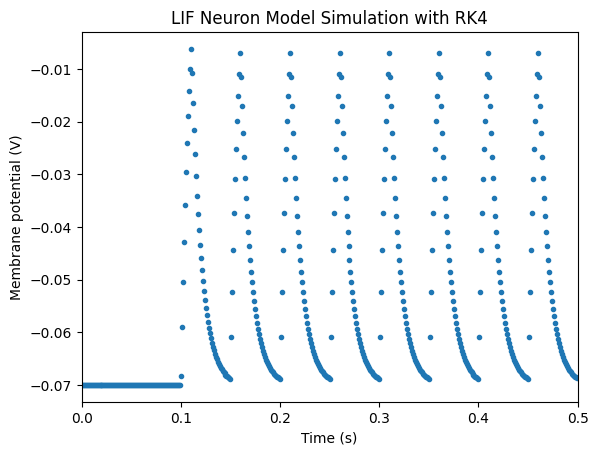

In [13]:
# given the same dt we look the multiple input current effect

import time

dt = 0.001
for numMethod in ['FE', 'BE', 'Heun', 'RK4']:
    start_time = time.time()    
    t, V = LIF(tau_m, R_m, V_rest, I, V_init, dt, t_final, numMethod)
    end_time = time.time()
    time_taken = end_time - start_time
    print(numMethod + " time taken: ", round(time_taken,6), "seconds")
    # Plot voltage trace
    plt.plot(t, V, '.')
    plt.xlabel('Time (s)')
    plt.ylabel('Membrane potential (V)')
    plt.title('LIF Neuron Model Simulation with ' + numMethod)
    plt.xlim(0, t_final)
    plt.show()

FE time taken:  0.025231 seconds


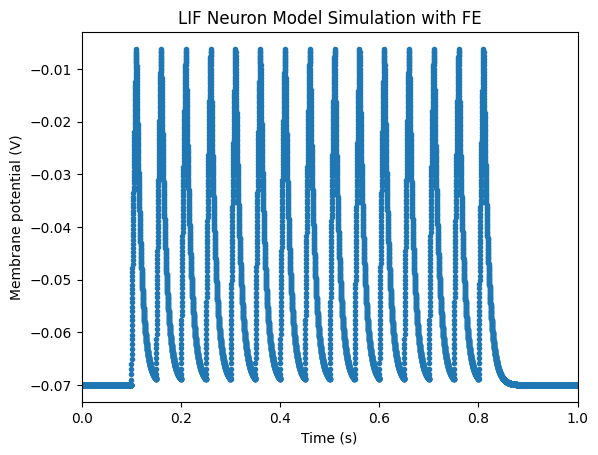

BE time taken:  0.023168 seconds


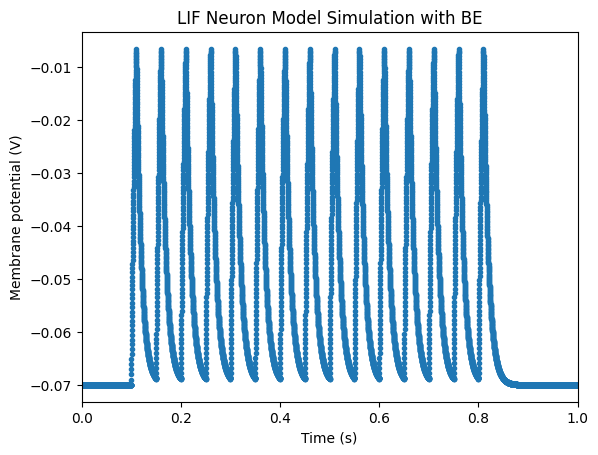

Heun time taken:  0.043301 seconds


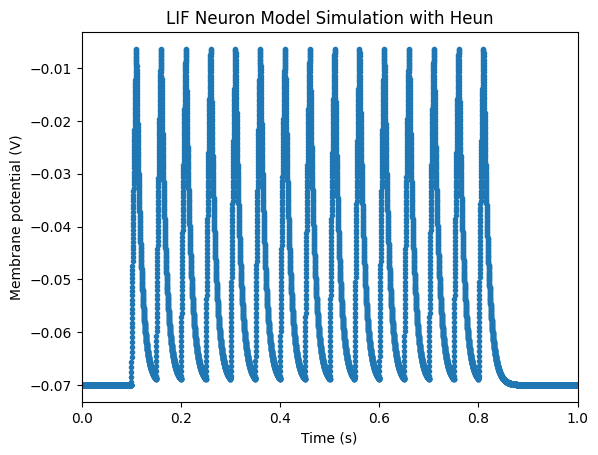

RK4 time taken:  0.089342 seconds


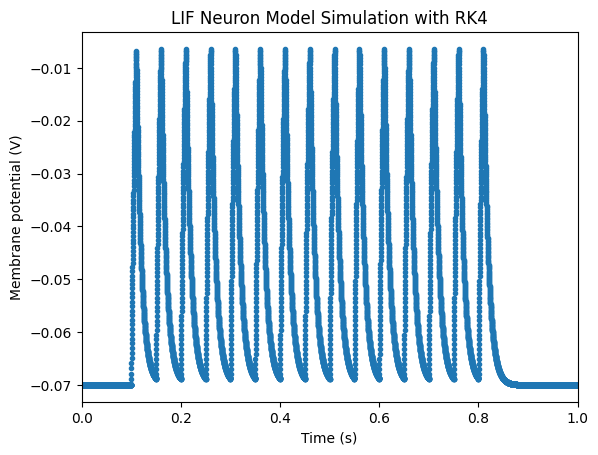

In [14]:
# decimal of the ref dt we look the multiple input current effect

import time

dt = 0.001/10
t_final = 1
for numMethod in ['FE', 'BE', 'Heun', 'RK4']:
    start_time = time.time()    
    t, V = LIF(tau_m, R_m, V_rest, I, V_init, dt, t_final, numMethod)
    end_time = time.time()
    time_taken = end_time - start_time
    print(numMethod + " time taken: ", round(time_taken,6), "seconds")
    # Plot voltage trace
    plt.plot(t, V, '.')
    plt.xlabel('Time (s)')
    plt.ylabel('Membrane potential (V)')
    plt.title('LIF Neuron Model Simulation with ' + numMethod)
    plt.xlim(0, t_final)
    plt.show()

### overview

In [15]:
# range of different dt and check the computational time

t_final = 1
TIME = []
for dt in np.linspace(0.001,0.001/100, 100):
    for numMethod in ['FE', 'BE', 'Heun', 'RK4']:
        start_time = time.time()    
        t, V = LIF(tau_m, R_m, V_rest, I, V_init, dt, t_final, numMethod)
        end_time = time.time()
        time_taken = end_time - start_time
        TIME += [[numMethod, dt, time_taken]]
        #print(numMethod + " time taken: ", round(time_taken,6), "seconds")

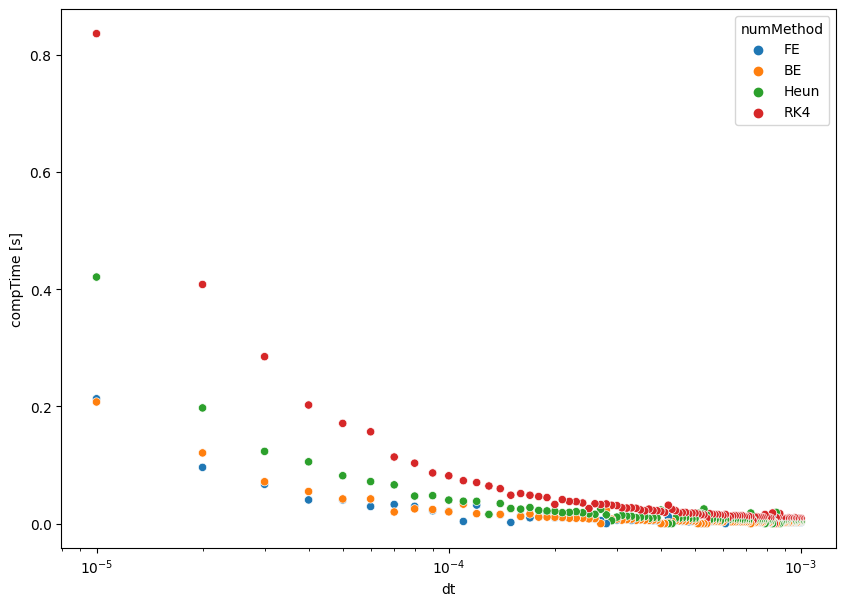

In [16]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(TIME, columns=['numMethod', 'dt', 'compTime [s]'])

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='dt', y='compTime [s]', hue='numMethod')

plt.xscale('log')
#plt.yscale('log')
#plt.savefig('./computation_time.jpeg', dpi=300, background='white')

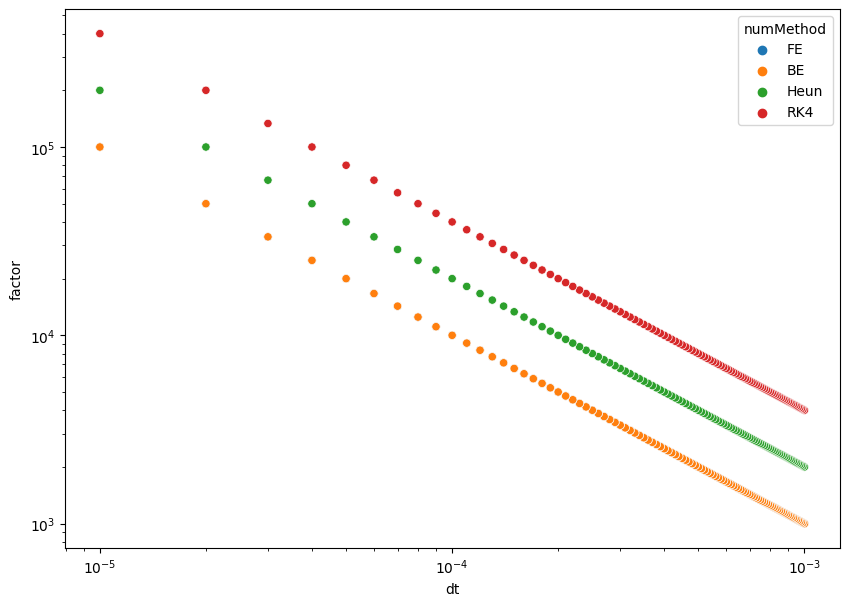

In [17]:
FACTOR = []
for dt in np.linspace(0.001,0.001/100, 100):
    for numMethod in ['FE', 'BE', 'Heun', 'RK4']:
        if numMethod == 'FE' or 'BE': EXP=1
        if numMethod == 'Heun': EXP=2
        if numMethod == 'RK4': EXP=4
        FACTOR += [[numMethod, dt, 1/dt*EXP]]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pd.DataFrame(data=FACTOR, columns=['numMethod', 'dt', 'factor']), x='dt', y='factor', hue='numMethod')
plt.xscale('log')
plt.yscale('log')

## accuracy

In [18]:
def I(t):
    pulse_dur = 0.01 # duration of each pulse in seconds
    pulse_interval = 0.1 # time interval between pulses in seconds
    num_pulses = 100 # number of pulses
    
    pulse_start_times = np.arange(1, 0.1 + num_pulses*pulse_interval, pulse_interval)
    
    for start_time in pulse_start_times:
        if t >= start_time and t <= start_time + pulse_dur:
            return 1e-9 # 1nA current input for pulse duration
    return 0.0 # no input current otherwise

t_final=11 # secondS

### Reference solution

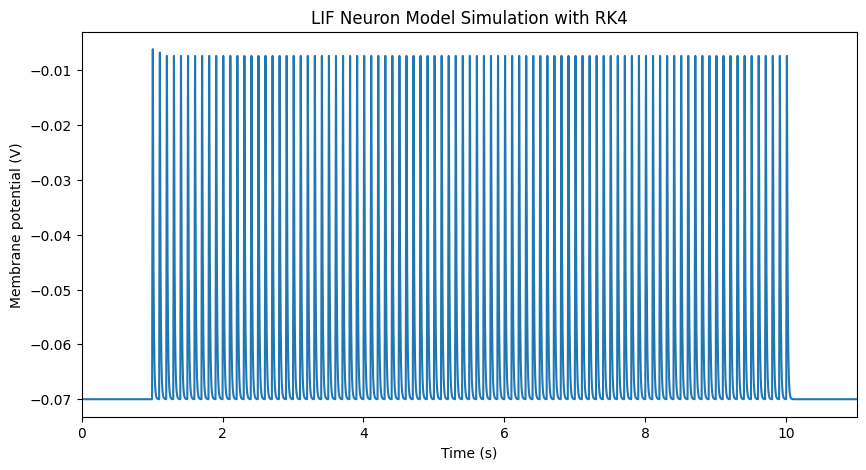

In [19]:
dt = 0.001
for numMethod in ['RK4']:
    t, V = LIF(tau_m, R_m, V_rest, I, V_init, dt, t_final, numMethod)

plt.figure(figsize=(10, 5))
plt.plot(t, V)#, ':')
plt.xlabel('Time (s)')
plt.ylabel('Membrane potential (V)')
plt.title('LIF Neuron Model Simulation with ' + numMethod)
plt.xlim(0, t_final)
plt.show()

### Test

In [20]:
# Reference solution
ref_t, ref_V = LIF(tau_m, R_m, V_rest, I, V_rest, dt, t_final, 'RK4')

# Numerical solution alternatives
fe_t, fe_V = LIF(tau_m, R_m, V_rest, I, V_rest, dt, t_final, 'FE')
be_t, be_V = LIF(tau_m, R_m, V_rest, I, V_rest, dt, t_final, 'BE')
heun_t, heun_V = LIF(tau_m, R_m, V_rest, I, V_rest, dt, t_final, 'Heun')

# MSE and MAE
fe_mse = np.mean((fe_V - ref_V)**2)
be_mse = np.mean((be_V - ref_V)**2)
heun_mse = np.mean((heun_V - ref_V)**2)

fe_mae = np.max(np.abs(fe_V - ref_V))
be_mae = np.max(np.abs(be_V - ref_V))
heun_mae = np.max(np.abs(heun_V - ref_V))


In [21]:
# MSE sorted
mse_values = {'FE': fe_mse, 'BE': be_mse, 'Heun': heun_mse}
sorted_mse = sorted(mse_values.items(), key=lambda x: x[1], reverse=True)

print("MSE (sorted):")
print(" ")
for method, mse in sorted_mse:
    print(f"{method}: {mse:.10f}")
    
print(' ')

MSE (sorted):
 
FE: 0.0000031956
Heun: 0.0000005493
BE: 0.0000002347
 


In [22]:
# MAE sorted
mae_values = {'FE': fe_mae, 'BE': be_mae, 'Heun': heun_mae}
sorted_mae = sorted(mae_values.items(), key=lambda x: x[1], reverse=True)

print("MAE (sorted):")
print(" ")
for method, mae in sorted_mae:
    print(f"{method}: {mae:.5f}")

MAE (sorted):
 
FE: 0.00991
BE: 0.00910
Heun: 0.00646
